## Getting started with BombCell

## Install bombcell

Create a conda environment
```bash
conda create -n bombcell python=3.11
conda activate bombcell
```
Clone latest bombcell repository from github
```bash
git clone https://github.com/Julie-Fabre/bombcell.git
```
Install bombcell from local repository
```bash
cd bombcell/pyBombCell
# you could do `pip install .`, but uv is much quicker!
pip install uv
uv pip install . # or uv pip install -e . (-e for editable mode)
```

## Imports

In [20]:
import os, sys
from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)
import matplotlib.pyplot as plt

In [21]:
# Optional

# # Add bombcell to Python path if NOT installed with pip
# # If notebook is running in bombcell repo:
# demo_dir = Path(os.getcwd())
# pyBombCell_dir = demo_dir.parent
# # Else:
# # pyBombCell_dir = "path/to/bombcell/repository/root"
# sys.path.append(str(pyBombCell_dir))

In [22]:
%load_ext autoreload
%autoreload 2

import bombcell as bc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define data paths

By default: path to BombCell's toy dataset

In [23]:
# Replace with your kilosort directory
ks_dir = Path(os.getcwd()) / "toy_data" 

# Set bombcell's output directory
save_path = Path(ks_dir) / "bombcell"

In [24]:
## For Neuropixels probes, provide raw and meta files
# Leave 'None' if no raw data
raw_file_path = None # "path/to/rawdata.ap.bin"
meta_file_path = None # "path/to/metadata.ap.meta"

# Handle cases where raw data is compressed and fetch metadata uV conversion factor
ephys_raw_data, gain_to_uV = None, None
if raw_file_path is not None:
    ephys_raw_data = bc.manage_data_compression(Path(raw_file_path).parent)
if meta_file_path is not None:
    gain_to_uV = bc.get_gain_spikeglx(meta_file_path)

In [25]:
## For non-Neuropixels probes, specify conversion factor to uV
# ephys_raw_data = "" # .bin, .dat...
# gain_to_uV = None
# sampling_rate = 30_000
# n_channels = 385
# n_bytes_per_sample = 2 # 2 bytes if int16, 4 if int32...

## Get parameters

In [26]:
param = bc.get_default_parameters(ks_dir, 
                                  raw_file=ephys_raw_data,
                                  ephys_meta_dir=meta_file_path)

print("BombCell parameters:")
pprint(param)

BombCell parameters:
{'compute_distance_metrics': False,
 'compute_drift': False,
 'compute_spatial_decay': True,
 'compute_time_chunks': False,
 'decompress_data': False,
 'delta_time_chunk': 360,
 'detrend_waveform': True,
 'drift_bin_size': 60,
 'duplicate_spikes_window_s': 1e-05,
 'ephys_kilosort_path': '/home/julie/Dropbox/Python/bombcell/pyBombCell/Demos/toy_data',
 'ephys_meta_file': None,
 'ephys_sample_rate': 30000,
 'extract_raw_waveforms': True,
 'gain_to_uV': None,
 'iso_d_min': 20,
 'keep_only_somatic': True,
 'lratio_max': 0.1,
 'max_RPV': 0.1,
 'max_drift': 100,
 'max_main_peak_to_trough_ratio_non_somatic': 0.8,
 'max_n_peaks': 2,
 'max_n_troughs': 1,
 'max_peak1_to_peak2_ratio_non_somatic': 3,
 'max_perc_spikes_missing': 20,
 'max_scnd_peak_to_trough_ratio_noise': 0.8,
 'max_spatial_decay_slope_exp': -0.1,
 'max_wv_baseline_fraction': 0.3,
 'max_wv_duration': 1150,
 'min_SNR': 1,
 'min_amplitude': 20,
 'min_num_spikes_total': 300,
 'min_presence_ratio': 0.7,
 'min_spati

### Optionally customize parameters

In [27]:
# param["max_RPV"] = 0.1
# param["compute_distance_metrics"] = 1
# param["compute_drift"] = 1
# param["compute_time_chunks"] = 0
# param['re_extract_raw'] = False
# ...

## Run bombcell, get unit types and save results 

Computing bombcell quality metrics:   0%|          | 0/15 units

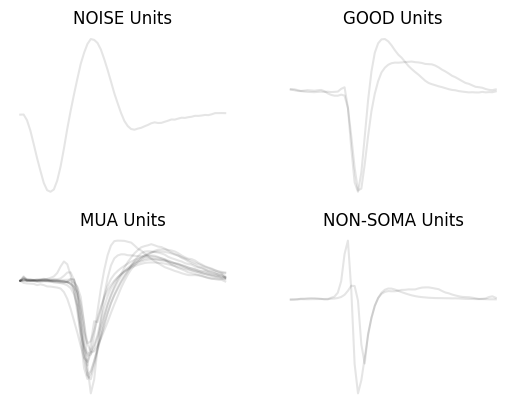

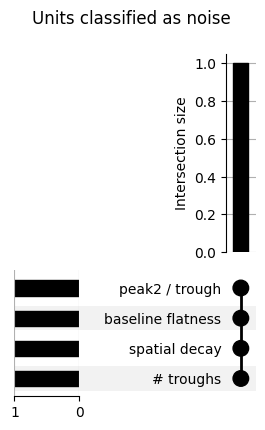

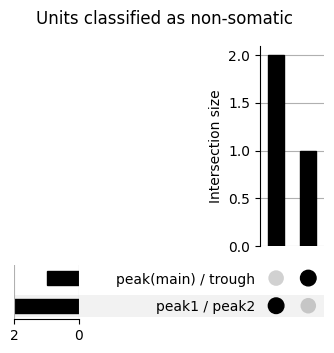

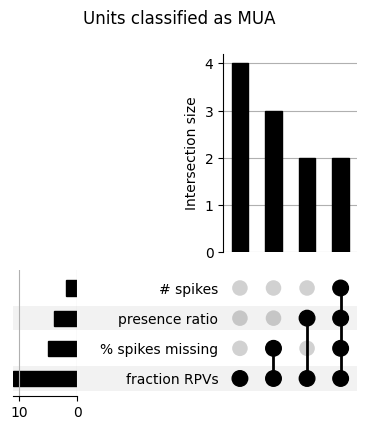

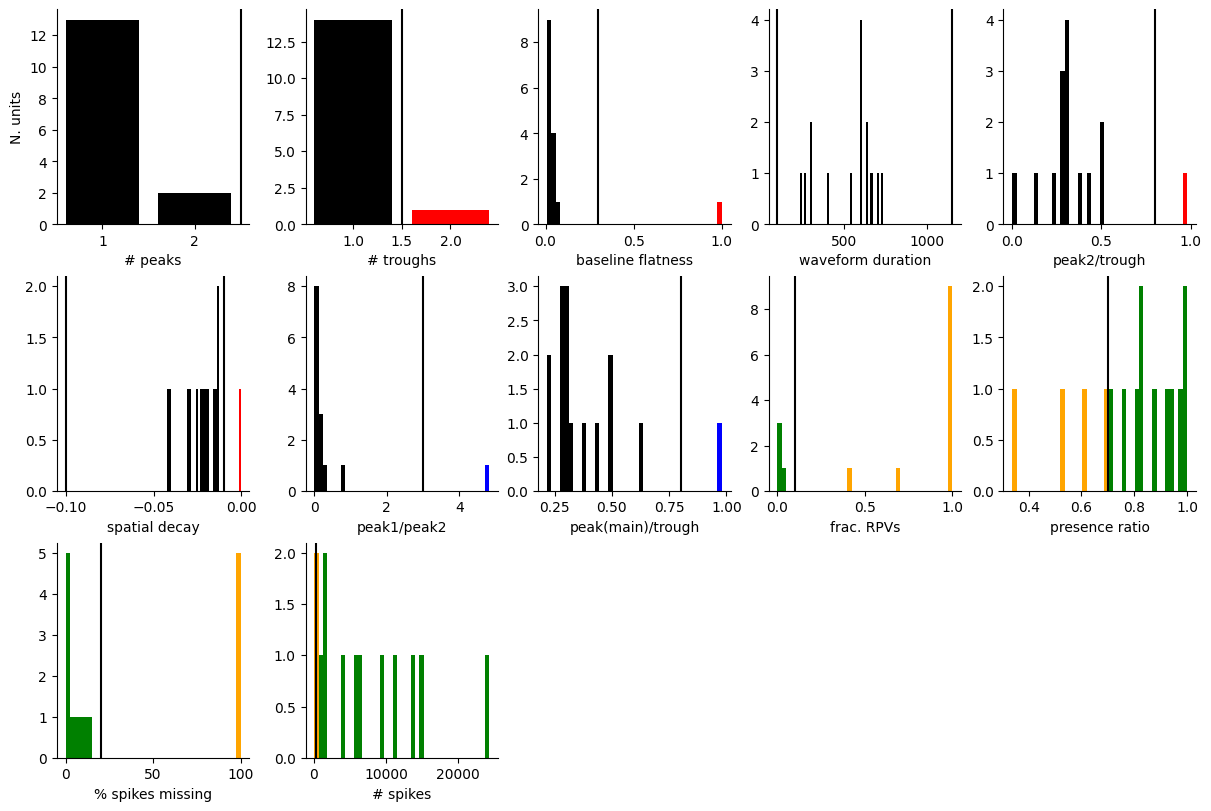

All expected metrics were successfully saved.


In [28]:
(
    quality_metrics,
    param,
    unit_type,
    unit_type_string,
) = bc.run_bombcell(
        ks_dir, save_path, param
)

Reload quality metrics table

In [29]:
# quality metric values
quality_metrics_table = pd.DataFrame(quality_metrics)
quality_metrics_table.insert(0, 'Bombcell_unit_type', unit_type_string)
quality_metrics_table

,Bombcell_unit_type,phy_clusterID,nSpikes,nPeaks,nTroughs,waveformDuration_peakTrough,spatialDecaySlope,waveformBaselineFlatness,scndPeakToTroughRatio,mainPeakToTroughRatio,peak1ToPeak2Ratio,troughToPeak2Ratio,mainPeak_before_width,mainTrough_width,percentageSpikesMissing_gaussian,percentageSpikesMissing_symmetric,RPV_window_index,fractionRPVs,presenceRatio,maxDriftEstimate,cumDriftEstimate,rawAmplitude,signalToNoiseRatio,isolationDistance,Lratio,silhouetteScore,useTheseTimesStart,useTheseTimesStop,peak_channels
0,MUA,0,9705.0,1.0,1.0,600.000000,-0.042352,0.021372,0.312463,0.312463,0.283650,11.282845,2.832360,7.318890,11.685531,27.709497,0.0,1.000000,0.756757,24.972344,222.087749,NaN,NaN,NaN,NaN,NaN,0.325367,4475.873933,0
1,NOISE,1,24343.0,1.0,2.0,400.000000,-0.000496,1.000000,0.980433,0.980433,0.001438,709.481628,NaN,8.092349,100.000000,31.484140,0.0,1.000000,1.000000,42.515827,383.897898,NaN,NaN,NaN,NaN,NaN,0.325367,4475.873933,0
2,MUA,2,5906.0,1.0,1.0,733.333333,-0.025323,0.048061,0.431882,0.431882,0.111282,20.806959,0.948645,8.875602,100.000000,22.074152,0.0,1.000000,0.972973,73.389266,453.775656,NaN,NaN,NaN,NaN,NaN,0.325367,4475.873933,2
3,MUA,3,1342.0,1.0,1.0,300.000000,-0.040807,0.014625,0.234792,0.234792,0.021125,201.614166,NaN,4.099461,7.891646,20.872642,0.0,1.000000,0.810811,49.149593,632.523427,NaN,NaN,NaN,NaN,NaN,0.325367,4475.873933,2
4,MUA,4,3784.0,2.0,1.0,600.000000,-0.013389,0.057277,0.304664,0.304664,0.844419,3.887054,3.345621,8.822806,12.775031,41.360607,0.0,1.000000,0.945946,65.015079,406.069652,NaN,NaN,NaN,NaN,NaN,0.325367,4475.873933,4
5,MUA,5,6454.0,1.0,1.0,666.666667,-0.028866,0.044926,0.297345,0.297345,0.151091,22.258665,NaN,6.191829,2.995993,2.330508,0.0,0.982238,0.527027,34.258558,362.233033,NaN,NaN,NaN,NaN,NaN,0.325367,4475.873933,6
6,GOOD,6,13605.0,1.0,1.0,266.666667,-0.020930,0.026933,0.492256,0.492256,0.042574,47.715912,NaN,4.136663,0.000000,7.139932,0.0,0.032903,0.824324,52.689211,170.088576,NaN,NaN,NaN,NaN,NaN,0.325367,4475.873933,6
7,MUA,7,171.0,1.0,1.0,600.000000,-0.014845,0.019374,0.288174,0.288174,0.067231,51.614994,NaN,4.139432,100.000000,35.955056,0.0,1.000000,0.689189,53.153589,702.260547,NaN,NaN,NaN,NaN,NaN,0.325367,4475.873933,5
8,MUA,8,390.0,1.0,1.0,600.000000,-0.015257,0.045225,0.303427,0.303427,0.149049,22.111492,NaN,5.895327,0.220368,0.000000,0.0,0.676498,0.878378,44.889622,566.454679,NaN,NaN,NaN,NaN,NaN,0.325367,4475.873933,9
9,MUA,9,75.0,1.0,1.0,633.333333,-0.019839,0.029477,0.292315,0.292315,0.100840,33.924671,NaN,5.698128,100.000000,30.555556,0.0,1.000000,0.337838,64.342559,393.136776,NaN,NaN,NaN,NaN,NaN,0.325367,4475.873933,11


In [30]:
# boolean table, if quality metrics pass threshold given parameters
boolean_quality_metrics_table = bc.make_qm_table(
    quality_metrics, param, unit_type_string
)
boolean_quality_metrics_table

,unit_type,Original ID,NaN result,# peaks,# troughs,duration,baseline flatness,peak2 / trough,spatial decay,# spikes,% spikes missing,presence ratio,fraction RPVs,non somatic,peak(main) / trough,peak1 / peak2
0,MUA,0,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,NOISE,1,False,False,True,False,True,True,True,False,True,False,True,True,True,False
2,MUA,2,False,False,False,False,False,False,False,False,True,False,True,False,False,False
3,MUA,3,False,False,False,False,False,False,False,False,False,False,True,False,False,False
4,MUA,4,False,False,False,False,False,False,False,False,False,False,True,False,False,False
5,MUA,5,False,False,False,False,False,False,False,False,False,True,True,False,False,False
6,GOOD,6,False,False,False,False,False,False,False,False,False,False,False,False,False,False
7,MUA,7,False,False,False,False,False,False,False,True,True,True,True,False,False,False
8,MUA,8,False,False,False,False,False,False,False,False,False,False,True,False,False,False
9,MUA,9,False,False,False,False,False,False,False,True,True,True,True,False,False,False


Example: get all quality metrics for unit 10

In [32]:
u = 12

units = quality_metrics_table.phy_clusterID
quality_metrics_table.loc[units == u, :]

,Bombcell_unit_type,phy_clusterID,nSpikes,nPeaks,nTroughs,waveformDuration_peakTrough,spatialDecaySlope,waveformBaselineFlatness,scndPeakToTroughRatio,mainPeakToTroughRatio,peak1ToPeak2Ratio,troughToPeak2Ratio,mainPeak_before_width,mainTrough_width,percentageSpikesMissing_gaussian,percentageSpikesMissing_symmetric,RPV_window_index,fractionRPVs,presenceRatio,maxDriftEstimate,cumDriftEstimate,rawAmplitude,signalToNoiseRatio,isolationDistance,Lratio,silhouetteScore,useTheseTimesStart,useTheseTimesStop,peak_channels
12,MUA,12,14750.0,1.0,1.0,300.0,-0.013697,0.077735,0.49462,0.49462,0.088362,22.880278,NaN,6.52303,100.0,0.0,0.0,1.0,1.0,30.6275,191.151639,NaN,NaN,NaN,NaN,NaN,0.325367,4475.873933,12
